This notebook finds the skin tone from images given a folder path

In [2]:
#data_dir = 'images'
#data_dir = '/Users/kalilamali/Desktop/THESIS/binary_data/scratch/s181423_data/binary/skin/SD-260'
#data_dir = '/Users/kalilamali/Documents/DTU/Semester4/recreation_of_isic_2019_for_gpu/dataset/isic19/images'
data_dir = '/Users/kalilamali/Desktop/ham10000/HAM10000/'
#data_name = 'SD-260'
#data_name = 'ISIC_2019'
data_name = 'HAM10000'

In [3]:
# Requirements
#! pip install opencv-python

In [4]:
# Libraries
import os
import cv2
import math
import numpy as np
import pandas as pd
import skimage
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

## Classify the color according to the individual topology angle
https://onlinelibrary.wiley.com/doi/pdf/10.1111/bjd.12529
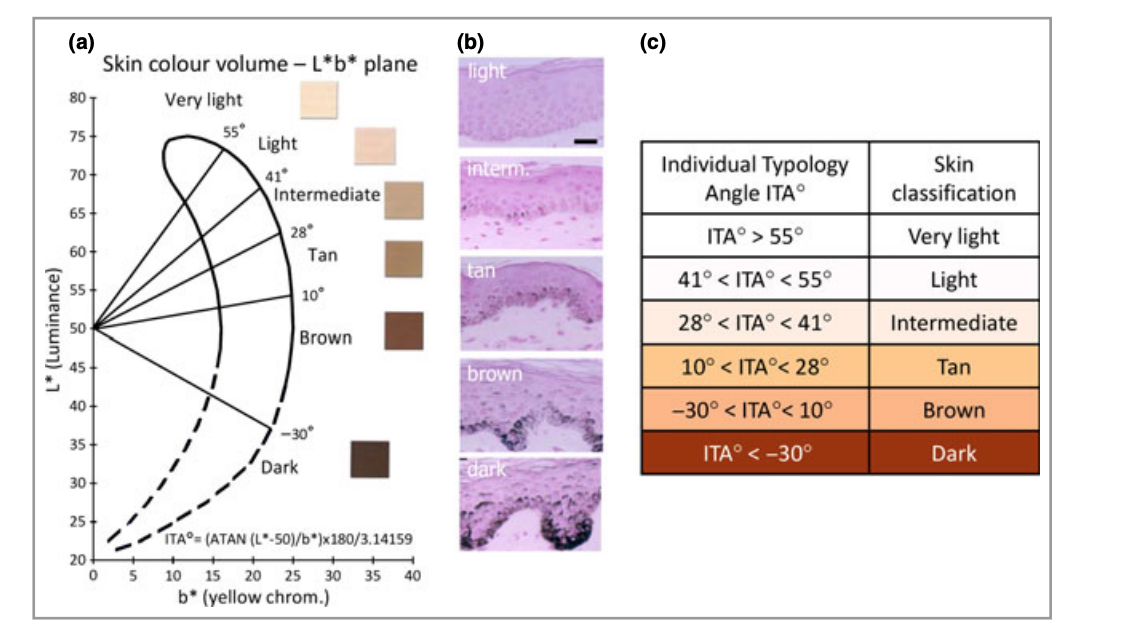

In [5]:
# Helper functions
def run_fast_scandir(dir, ext):    # dir: str, ext: list
    """
    Function that takes a path and an extension
    and returns a list of file paths with that extension.
    """
    files = []
    for f in os.scandir(dir):
        if f.is_dir():
            subfolder = f.path
            subfiles = run_fast_scandir(subfolder, ext)
            files.extend(subfiles)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                files.append(f.path)
    return files


# Segment image using otsu binarization and thresholding
def segment_otsu(img_grayscale, img_BGR_small):
    threshold_value, threshold_image = cv2.threshold(img_grayscale, 0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    threshold_image_binary = 1- threshold_image/255
    threshold_image_binary = np.repeat(threshold_image_binary[:, :, np.newaxis], 3, axis=2)
    img_face_only = np.multiply(threshold_image_binary, img_BGR_small)
    img_face_only = img_face_only.astype(np.uint8)
    return img_face_only


def get_skin_tone_estimate_RGB(img_HSV, img_YCrCb, img_face_only):
    # Aggregate skin pixels
    blue = []
    green = []
    red = []

    height, width, channels = img_face_only.shape

    for i in range (height):
        for j in range (width):
            if((img_HSV.item(i, j, 0) <= 170) and (140 <= img_YCrCb.item(i, j, 1) <= 170) and (90 <= img_YCrCb.item(i, j, 2) <= 120)):
                blue.append(img_face_only[i, j].item(0))
                green.append(img_face_only[i, j].item(1))
                red.append(img_face_only[i, j].item(2))
            else:
                img_face_only[i, j] = [0, 0, 0]
    
    if (blue == []) and (green == [] and red == []):
        skin_tone_estimate_RGB = None
    else:
        # Determine mean skin tone estimate in RGB
        skin_tone_estimate_RGB = [np.mean(red), np.mean(green), np.mean(blue)]
        #print ("mean skin tone estimate (RGB)", skin_tone_estimate_RGB[0], skin_tone_estimate_RGB[1], skin_tone_estimate_RGB[2], "]")
    
    return skin_tone_estimate_RGB

def ita_2_tone(ita):
    if ita > 55:
        return 'Very light'
    if 41 < ita <=55:
        return 'Light'
    if 28 < ita <=41:
        return 'Intermediate'
    if 10 < ita <= 28:
        return 'Tan'
    if -30 < ita <= 10:
        return 'Brown'
    if ita <= -30:
        return 'Dark'
    if ita != ita:
        return 'undetermined'
    
def image_to_ita_tone(img_BGR):
    
    # Resize image
    img_BGR_small = cv2.resize(img_BGR, (0, 0), fx = 0.1, fy = 0.1)
    
    # Convert to grayscale
    img_grayscale = cv2.cvtColor(img_BGR_small, cv2.COLOR_BGR2GRAY)
    
    # Foreground and background segmentation (otsu)
    img_face_only = segment_otsu(img_grayscale, img_BGR_small)
    
    # Convert to HSV and YCrCb color spaces and detect potential pixels
    img_HSV = cv2.cvtColor(img_face_only, cv2.COLOR_BGR2HSV)
    img_YCrCb = cv2.cvtColor(img_face_only, cv2.COLOR_BGR2YCrCb)
    
    # Get skin tone estimate
    skin_tone_estimate_RGB = get_skin_tone_estimate_RGB(img_HSV, img_YCrCb, img_face_only)
    
    if skin_tone_estimate_RGB is None:
        ita_tone = 'undetermined'
    else:
        # Rescale skin tone
        tone_rgb = [[[x/255 for x in skin_tone_estimate_RGB]]]

        # Convert to LAB color space
        tone_lab = color.rgb2lab(tone_rgb)

        # Get individual colors in LAB color space
        l,a,b = tone_lab.flatten()

        # Calculate ita angle
        ita = np.arctan((l-50)/b)*(180/math.pi)
        ita_tone = ita_2_tone(ita)
    return ita_tone

In [6]:
# Get the image paths
filenames = run_fast_scandir(data_dir, [".jpg"])
df = pd.DataFrame(data=filenames, columns=['image_path'])
df['image_id'] = df['image_path'].apply(lambda x:os.path.splitext(os.path.basename(x))[0])
df = df.set_index('image_id')
#df.sample(3)

In [7]:
len(df)

10015

In [8]:
# Load in all of the images
df['img_BGR'] = df['image_path'].map(cv2.imread)
#df.sample(3)

In [9]:
# Get the ita tone in a column
df['ita_tone'] = df['img_BGR'].apply(lambda x: image_to_ita_tone(x))
#df.sample(3)

In [10]:
test = pd.DataFrame(df['ita_tone'].value_counts())
test = test.reset_index()
test = test.rename(columns={"index": "Skin tone", "ita_tone":"Counts"})
test.to_excel(f"{data_name}_ita_tone_stats.xlsx", sheet_name='Sheet_name_1',index=False)
test

,Skin tone,Counts
0,Very light,3584
1,Light,2837
2,undetermined,1285
3,Intermediate,1203
4,Tan,672
5,Brown,396
6,Dark,38


In [11]:
test = test.set_index("Skin tone")
test

,Counts
Skin tone,
Very light,3584
Light,2837
undetermined,1285
Intermediate,1203
Tan,672
Brown,396
Dark,38


In [12]:
test = test.drop(['undetermined'], axis=0)
test

,Counts
Skin tone,
Very light,3584
Light,2837
Intermediate,1203
Tan,672
Brown,396
Dark,38


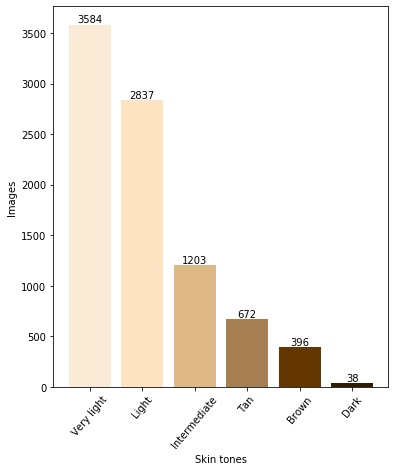

In [13]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# Make a fake dataset
height = test['Counts']
bars = test.index
y_pos = np.arange(len(bars))

# Grab only the colors that appear
colors = []
mycolors = {'Very light':'antiquewhite', 'Light':'bisque', 'Intermediate':'burlywood', 'Tan':'xkcd:puce', 'Brown':'xkcd:brown', 'Dark':'xkcd:dark brown'}
for key in mycolors.keys():
    if key in bars:
        colors.append(mycolors[key])

fig = plt.figure(figsize=(len(bars),len(bars)+1))
ax = plt.bar(y_pos, height, color=colors)
plt.xticks(y_pos, bars, rotation=50)
plt.ylabel('Images')
plt.xlabel('Skin tones')

rects = ax.patches

# Make some labels.
labels = height

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')
plt.show()
fig.savefig(f'{data_name}_skin_tones_bars.png', dpi=300,bbox_inches="tight")